## Subgroup B Q2
#### What pricing strategies can we implement to maximize revenue?
- Analyze price elasticity for different product categories.
- Develop a dynamic pricing model based on demand and competition.

OVERVIEW OF THIS FILE
1. Dataset Selection and cleaning
2. Grouping products into product categories
3. Calculating Price Elasticity
4. Analyzing price elasticity based on product categories
5. Calculating a demand score for each product
6. Calculating a competition score for each product
7. Building the dynamic pricing model
8. Final analysis 

#### 1. DATASET SELECTION AND CLEANING

We chose to use `online_retail_clean` dataset as it has the `UnitPrice`and `Quantity` columns which are useful in helping us calculate the price elasticies of each unique `Description`. 

In [1]:
import pandas as pd
import numpy as np

filename = "online_retail_clean.csv"
online_retail = pd.read_csv(filename)
online_retail.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


We move on to data exploration and drop rows with 
1. out-of-range values such as `Quantity` < 0 and `UnitPrice` > 0. 
2. `Description` with length < 10 to ensure sufficient sample size for each product.

In [2]:
#drop rows with negative quantity
online_retail = online_retail[online_retail['Quantity'] > 0]

#drop rows with unit price <=0
online_retail = online_retail[online_retail['UnitPrice'] > 0]

#drop rows with description < 10 
description_counts = online_retail['Description'].value_counts()
valid_descriptions = description_counts[description_counts >= 10].index.tolist()
online_retail = online_retail[online_retail['Description'].isin(valid_descriptions)]

#print number of unique descriptions with length >= 10
print(len(valid_descriptions)) 
#print  number of rows in filtered dataframe 
print(len(online_retail))  

3215
521565


#### 2. GROUPING PRODUCTS INTO PRODUCT CATEGORIES

We used k_means clustering to 

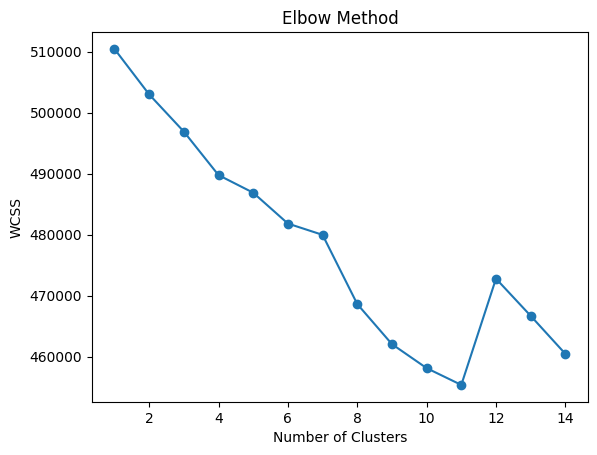

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Vectorize the 'Description' column
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
description_vectors = tfidf.fit_transform(online_retail['Description'])

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 15):  # Try different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(description_vectors)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values to visualize the "elbow"
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [22]:
# Apply K-means clustering
# Choose a suitable number of clusters (e.g., 10). You may need to experiment with this number.
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
online_retail['CategoryCluster'] = kmeans.fit_predict(description_vectors)

# Print sample descriptions in each cluster to understand category themes
for i in range(num_clusters):
    cluster_descriptions = online_retail[online_retail['CategoryCluster'] == i]['Description'].head(10)
    print(f"Cluster {i}:\n", cluster_descriptions, "\n")

result = online_retail[['Description', 'CategoryCluster']]
result

Cluster 0:
 14     BOX OF 6 ASSORTED COLOUR TEASPOONS
15          BOX OF VINTAGE JIGSAW BLOCKS 
16         BOX OF VINTAGE ALPHABET BLOCKS
35                    SPACEBOY LUNCH BOX 
36                LUNCH BOX I LOVE LONDON
37               CIRCUS PARADE LUNCH BOX 
65             VICTORIAN SEWING BOX LARGE
94      STRAWBERRY LUNCH BOX WITH CUTLERY
95      LUNCH BOX WITH CUTLERY RETROSPOT 
216            ROSE COTTAGE KEEPSAKE BOX 
Name: Description, dtype: object 

Cluster 1:
 5            SET 7 BABUSHKA NESTING BOXES
21               JAM MAKING SET WITH JARS
33        SET/2 RED RETROSPOT TEA TOWELS 
34    ROUND SNACK BOXES SET OF4 WOODLAND 
40        SET 2 TEA TOWELS I LOVE LONDON 
63           SET 7 BABUSHKA NESTING BOXES
80           SET 7 BABUSHKA NESTING BOXES
90      RED 3 PIECE RETROSPOT CUTLERY SET
91      BLUE 3 PIECE POLKADOT CUTLERY SET
92          SET/6 RED SPOTTY PAPER PLATES
Name: Description, dtype: object 

Cluster 2:
 109           AIRLINE LOUNGE,METAL SIGN
117     YOU'RE

,Description,CategoryCluster
0,WHITE HANGING HEART T-LIGHT HOLDER,4
1,WHITE METAL LANTERN,3
2,CREAM CUPID HEARTS COAT HANGER,3
3,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,RED WOOLLY HOTTIE WHITE HEART.,4
...,...,...
535080,PACK OF 20 SPACEBOY NAPKINS,3
535081,CHILDREN'S APRON DOLLY GIRL,3
535082,CHILDRENS CUTLERY DOLLY GIRL,3
535083,CHILDRENS CUTLERY CIRCUS PARADE,3


In [25]:
# Mapping of clusters to categories based on sample descriptions
cluster_to_category = {
    0: "Storage & Lunch Boxes",
    1: "Kitchen Items",
    2: "Funny Metal Signs",
    3: "Home Decor & Toys",
    4: "Heart & Holiday Decor",
    5: "Greeting Cards & Card Holders",
    6: "Hot Water Bottles",
    7: "Vintage Gift Items"
}

# Map clusters to categories in the DataFrame
online_retail['Category'] = online_retail['CategoryCluster'].map(cluster_to_category)

#### 3. CALCULATING PRICE ELASTICITY

$$PED = \frac{\% \text{ change in quantity demanded}}{\% \text{ change in price}}$$ 
- To calculate the `Price_elasticity` using the formula above, we group `online_retail` by `Description` and `UnitPrice` before agregating the total `Quantity` sold for each unique description at its unique price.
- The PED is then calculated using the percentage change of `UnitPrice` and `Quantity` for products with the same `Description`.
- The dataframe `price_elasticity_df` contains the average price elasticity for each unique product description, removing extreme price elasticity values as a result of extremely low or high volumes only at certain price points which may not be a good representation of the actual `Price_elasticity` of that `Description`.

In [28]:
#group by Description and UnitPrice
grouped = online_retail.groupby(['Description', 'UnitPrice']).agg({'Quantity': 'sum'}).reset_index()

#calculate percentage changes of price and quantity
grouped["Price_change"] = grouped.groupby('Description')['UnitPrice'].pct_change()
grouped["Quantity_change"] = grouped.groupby('Description')['Quantity'].pct_change()

#calculate price elasticity
grouped["Price_elasticity"] = np.abs(grouped["Quantity_change"] / grouped["Price_change"])

#calculate mean price elasticity for each unique description
price_elasticity_df = (
    grouped[grouped["Price_elasticity"] < 10]  # Filter for valid elasticity values
    .groupby('Description')['Price_elasticity']
    .mean()
    .reset_index()
    .rename(columns={'Price_elasticity': 'Price_elasticity'})
)

print(price_elasticity_df)

                           Description  Price_elasticity
0        4 PURPLE FLOCK DINNER CANDLES          0.466911
1        50'S CHRISTMAS GIFT BAG LARGE          1.013606
2                    DOLLY GIRL BEAKER          1.396022
3          I LOVE LONDON MINI BACKPACK          0.955029
4              NINE DRAWER OFFICE TIDY          0.953892
...                                ...               ...
2939   ZINC T-LIGHT HOLDER STARS SMALL          2.990272
2940    ZINC TOP  2 DOOR WOODEN SHELF           0.829865
2941  ZINC WILLIE WINKIE  CANDLE STICK          2.720561
2942       ZINC WIRE KITCHEN ORGANISER          0.459674
2943  ZINC WIRE SWEETHEART LETTER TRAY          0.976181

[2944 rows x 2 columns]


#### 4. ANALYZING PRICE ELASTICITY BASED ON PRODUCT CATEGORIES

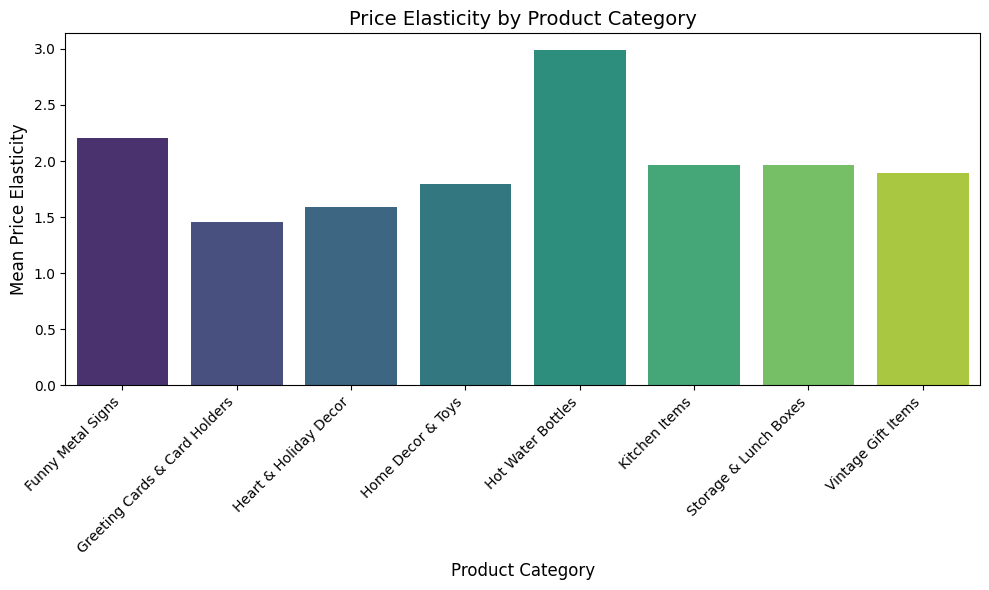

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the price elasticity data with the category data
category_price_elasticity = price_elasticity_df.merge(online_retail[['Description', 'Category']].drop_duplicates(), 
                                                      on='Description', how='left')

# Calculate the mean price elasticity for each category
category_price_elasticity_mean = category_price_elasticity.groupby('Category')['Price_elasticity'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_price_elasticity_mean, x='Category', y='Price_elasticity', palette='viridis')

# Set plot labels and title
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Mean Price Elasticity', fontsize=12)
plt.title('Price Elasticity by Product Category', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()


#### 5. CALCULATING A DEMAND SCORE OF EACH PRODUCT

- Add `TotalQuantity` to `price_elasticity_df` by taking the total `Quantity` of each unique `Description`
- Add `AvgUnitPrice` columns to `price_elasticity_df` by taking the average `UnitPrice` of each unique `Description`

In [144]:
#add total quantity and average unit price to price_elasticity_df
product_summary = (
    online_retail.groupby('Description')
    .agg(TotalQuantity=('Quantity', 'sum'), AvgUnitPrice=('UnitPrice', 'mean'))
    .reset_index()
)

#merge price_elasticity_df with product_summary
price_elasticity_df = price_elasticity_df.merge(
    product_summary,
    on='Description', 
    how='left'
)

price_elasticity_df.head()


,Description,Price_elasticity,TotalQuantity,AvgUnitPrice
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,142,2.450513
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,1915,1.426589
2,DOLLY GIRL BEAKER,1.396022,2451,1.506420
3,I LOVE LONDON MINI BACKPACK,0.955029,388,4.616667
4,NINE DRAWER OFFICE TIDY,0.953892,58,16.090606


- We use `TotalQuantity` as an indicator of demand because the quantity sold directly reflects consumer tastes and preferences. A higher quantity sold indicates a greater demand for the product.
- The 33<sup>rd</sup> and 66<sup>th</sup> percentile are calculated using the `TotalQuantity` column
- Add `Demand_Category` to `price_elasticity_df` using `categorize_demand()` where 
    - Low Demand: `TotalQuantity` less than the 33<sup>rd</sup> percentile
    - Medium  Demand: `TotalQuantity` between the 33<sup>rd</sup> and the 66<sup>th</sup> percentile
    - High Demand: `TotalQuantity` more than the 66<sup>th</sup> percentile

In [145]:
# calculate quantiles for the quantity column to categorise into low, medium and high demand
quantiles = price_elasticity_df['TotalQuantity'].quantile([0.33, 0.66]).values

#deine a function to categorize demand based on quantity
def categorize_demand(quantity):
    # Low demand
    if quantity < quantiles[0]:  
        return 'Low'
    # Medium demand
    elif quantity < quantiles[1]:  
        return 'Medium'
    # High demand
    else:  
        return 'High'

#apply the function to the grouped quantity column
price_elasticity_df['Demand_Category'] = price_elasticity_df['TotalQuantity'].apply(categorize_demand)


price_elasticity_df.head()

,Description,Price_elasticity,TotalQuantity,AvgUnitPrice,Demand_Category
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,142,2.450513,Low
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,1915,1.426589,High
2,DOLLY GIRL BEAKER,1.396022,2451,1.506420,High
3,I LOVE LONDON MINI BACKPACK,0.955029,388,4.616667,Medium
4,NINE DRAWER OFFICE TIDY,0.953892,58,16.090606,Low


#### 6. CALCULATING A COMPETITION SCORE FOR EACH PRODUCT

We then move on to calculating and coming up with a competition score for each row in `price_elasticity_df` based on the `Price_elasticity` and `TotalQuantity` values. 

We use `Price_elasticity` and `TotalQuantity` to determine competition levels. A combination of these factors reflects market dynamics and consumer preferences. The median of TotalQuantity is calculated to establish a reference point for competition scoring.

- Low Competition: Total score (from `Price_elasticity` and `TotalQuantity`) is less than or equal to 1
- Medium Competition: Total score is equal to 2
- High Competition: Total score is 3 or more

In [146]:
# Calculate the median of TotalQuantity
median_quantity = price_elasticity_df['TotalQuantity'].median()

def calculate_competition(row):
    # Score based on Price Elasticity
    if row['Price_elasticity'] < 1:
        price_elasticity_score = 0
    elif row['Price_elasticity'] == 1:
        price_elasticity_score = 1
    else:
        price_elasticity_score = 2

    # Score based on Total Quantity
    if row['TotalQuantity'] < median_quantity:
        total_quantity_score = 0
    elif row['TotalQuantity'] == median_quantity:
        total_quantity_score = 1
    else:
        total_quantity_score = 2

    # Total Competition Score
    total_score = price_elasticity_score + total_quantity_score
    
    # Determine competition category
    if total_score <= 1:
        competition = 'Low'
    elif total_score == 2:
        competition = 'Medium'
    else:  # total_score in [3, 4]
        competition = 'High'
    
    return competition

# Create the new DataFrame with competition scores
competition_score = price_elasticity_df[['Description']].copy()
competition_score['Competition'] = price_elasticity_df.apply(calculate_competition, axis=1)

price_elasticity_df = price_elasticity_df.merge(
    competition_score,
    on = 'Description',
    how = 'left'
)

price_elasticity_df

,Description,Price_elasticity,TotalQuantity,AvgUnitPrice,Demand_Category,Competition
0,4 PURPLE FLOCK DINNER CANDLES,0.466911,142,2.450513,Low,Low
1,50'S CHRISTMAS GIFT BAG LARGE,1.013606,1915,1.426589,High,High
2,DOLLY GIRL BEAKER,1.396022,2451,1.506420,High,High
3,I LOVE LONDON MINI BACKPACK,0.955029,388,4.616667,Medium,Low
4,NINE DRAWER OFFICE TIDY,0.953892,58,16.090606,Low,Low
...,...,...,...,...,...,...
2939,ZINC T-LIGHT HOLDER STARS SMALL,2.990272,5089,0.943673,High,High
2940,ZINC TOP 2 DOOR WOODEN SHELF,0.829865,13,21.094167,Low,Low
2941,ZINC WILLIE WINKIE CANDLE STICK,2.720561,2933,1.090849,High,High
2942,ZINC WIRE KITCHEN ORGANISER,0.459674,30,9.929375,Low,Low


#### 7. BUILDING THE DYNAMIC PRICING MODEL

This final code snippet uses all the new and raw features to generate an adjusted suggested price for the item moving forward usomg am `adjustment_factor` that takes into consideration `Demand_Category`, `Competition` and `Price_elasticity`

How it works:
- Sets a base `adjustment_factor` as 0 and is modified based on `demand_category` and `competition_score` which reflect market conditions
- Adjustment logic:
    - For Low Demand and Low Competition, the `adjustment_factor` is slightly negative to suggest a price reduction (e.g., -0.05).
    - For High Demand and Low Competition, the `adjustment_factor` increases (e.g., +0.10) to reflect that the product is in high demand but has little competition, allowing for a price increase.
    - Other combinations like Medium Demand and Medium Competition adjust the factor accordingly (e.g., +0.05 for moderate price increases).
- Elasticity scaling: After scaling `adjustment_factor` based on market conditions, `Price_elasticity` is applied to further scale the adjustment. If the product is highly elastic, the impact of the adjustment_factor is amplified and if demand is inelastic, the adjustment is less significant.

Why this order of scaling?
- The current design assumes that the direction (increase or decrease) of the price adjustment is primarily dictated by the market conditions (i.e., demand and competition). Elasticity is only affecting how significant that change will be.


This approach simplifies the logic and makes it easier to understand how market conditions interact with price adjustments.

In [147]:
def adjust_price(row):
    base_price = row['AvgUnitPrice']
    elasticity = row['Price_elasticity']
    demand_category = row['Demand_Category']
    competition_score = row['Competition']
    
    # Base adjustment factor
    adjustment_factor = 0

    # Adjust the price based on Demand Category and Competition Score
    if demand_category == 'High':
        if competition_score == 'High':
            adjustment_factor = -0.05  # Decrease for high demand and high competition
        elif competition_score == 'Medium':
            adjustment_factor = 0.05  # Increase slightly
        else:  # Low competition
            adjustment_factor = 0.10  # Higher increase for high demand and low competition
            
    elif demand_category == 'Medium':
        if competition_score == 'High':
            adjustment_factor = 0  # Maintain price for medium demand and high competition
        elif competition_score == 'Medium':
            adjustment_factor = 0.03  # Slight increase
        else:  # Low competition
            adjustment_factor = 0.05  # Moderate increase for medium demand and low competition
            
    else:  # Low demand
        if competition_score == 'High':
            adjustment_factor = -0.10  # Aggressive decrease for low demand and high competition
        elif competition_score == 'Medium':
            adjustment_factor = -0.05  # Moderate decrease
        else:  # Low competition
            adjustment_factor = 0  # No change for low demand and low competition
            
    # Calculate the adjusted price, with a cap on increases
    adjusted_price = base_price * (1 + adjustment_factor * elasticity)
    
    # Cap the maximum price increase to avoid excessive pricing
    if adjusted_price > base_price * 1.2:  # 20% cap on price increases
        adjusted_price = base_price * 1.2

    return adjusted_price

# Apply the price adjustment function to the original DataFrame
price_elasticity_df['Adjusted_Price'] = price_elasticity_df.apply(adjust_price, axis=1)

# Create a new DataFrame with only Description and Adjusted_Price
adjusted_price_df = price_elasticity_df[['Description', 'Adjusted_Price']]

adjusted_price_df

,Description,Adjusted_Price
0,4 PURPLE FLOCK DINNER CANDLES,2.450513
1,50'S CHRISTMAS GIFT BAG LARGE,1.354289
2,DOLLY GIRL BEAKER,1.401271
3,I LOVE LONDON MINI BACKPACK,4.837119
4,NINE DRAWER OFFICE TIDY,16.090606
...,...,...
2939,ZINC T-LIGHT HOLDER STARS SMALL,0.802581
2940,ZINC TOP 2 DOOR WOODEN SHELF,21.094167
2941,ZINC WILLIE WINKIE CANDLE STICK,0.942463
2942,ZINC WIRE KITCHEN ORGANISER,9.929375


#### 8. FINAL ANALYSIS